## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [9]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename='spam.csv')
data = pd.read_csv('spam.csv', encoding='latin-1')
print(len(data))
data

5572


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [12]:
data.columns

Index(['v1', 'v2'], dtype='object')

In [14]:
#del data['Unnamed: 2']
#del data['Unnamed: 3']
#del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])

In [15]:
data

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [18]:
data.drop_duplicates(subset=['v2'], inplace=True)
len(data)

5169

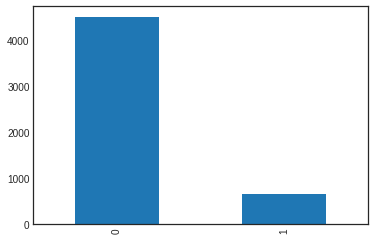

In [19]:
data['v1'].value_counts().plot(kind='bar');

In [20]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [21]:
X_data = data['v2']
y_data = data['v1']

In [23]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)


In [24]:
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [29]:
X_data = sequences

print('메일 최대 길이: {}'.format(max(len(l) for l in X_data)))
print('메일 평균 길이: {}'.format((sum(map(len, X_data))/len(X_data))))

메일 최대 길이: 172
메일 평균 길이: 12.566840781582512


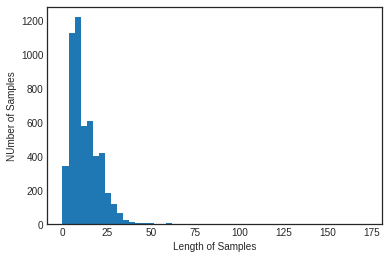

In [30]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('NUmber of Samples')
plt.show()

In [31]:
 max_len = 60
 data = pad_sequences(X_data, maxlen=max_len)
 print(data.shape)

(5169, 60)


In [33]:
n_train = int(len(sequences)* 0.8)
n_test = int(len(sequences) - n_train)

print(n_train)
print(n_test)

4135
1034


In [34]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])
X_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [35]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, 1, padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [40]:
es = EarlyStopping(monitor='val_loss' , mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### 모델 학습

In [41]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/10
52/52 [==============================] - 31s 12ms/step - loss: 0.5023 - acc: 0.8386 - val_loss: 0.3780 - val_acc: 0.8730

Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
Epoch 2/10
52/52 [==============================] - 0s 8ms/step - loss: 0.3790 - acc: 0.8697 - val_loss: 0.3495 - val_acc: 0.8730

Epoch 00002: val_acc did not improve from 0.87304
Epoch 3/10
52/52 [==============================] - 0s 7ms/step - loss: 0.2685 - acc: 0.8921 - val_loss: 0.1395 - val_acc: 0.9734

Epoch 00003: val_acc improved from 0.87304 to 0.97340, saving model to best_model.h5
Epoch 4/10
52/52 [==============================] - 0s 7ms/step - loss: 0.0836 - acc: 0.9791 - val_loss: 0.0545 - val_acc: 0.9831

Epoch 00004: val_acc improved from 0.97340 to 0.98307, saving model to best_model.h5
Epoch 5/10
52/52 [==============================] - 0s 7ms/step - loss: 0.0421 - acc: 0.9879 - val_loss: 0.0477 - val_acc: 0.9855

Epoch 00005: val_acc improved from 0.9830

### 시각화

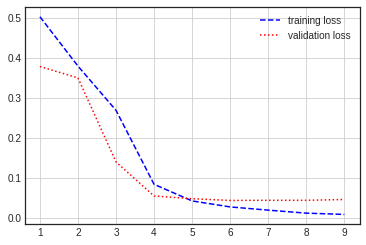

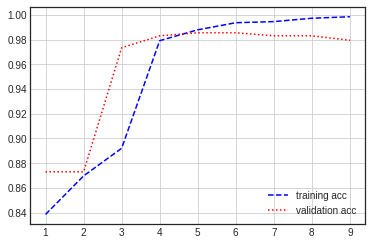

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='training acc')
plt.plot(epochs, val_acc, 'r:', label='validation acc')
plt.grid()
plt.legend()

plt.show()

In [44]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 3ms/step - loss: 0.0615 - acc: 0.9787


[0.0614706389605999, 0.978723406791687]